## Load Data

In [16]:
import random
import torch
from torchvision import models
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
import conformal.cp_lib as cp
import conformal.smoothers as sm 
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV

# Set seed, theme, and folder path
random.seed(47)
sns.set_theme(style="darkgrid")
folder = "./results"

holdout_results = torch.load(folder + "/holdout_predictions.pth", weights_only=False)
val_results = torch.load(folder + "/val_predictions.pth", weights_only=False)
test_results = torch.load(folder + "/test_predictions.pth", weights_only=False)

cal_labels = holdout_results["labels"]
cal_embeddings = holdout_results["latents"]

val_labels = val_results["labels"]
val_embeddings = val_results["latents"]

test_embeddings = test_results["latents"]
test_labels = test_results["labels"]

# CIFAR-10
cifar_labels = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]


### Define head model, final layer of trained model

In [17]:
# Define model architecture
model = models.resnet18(weights=None)
model.fc = nn.Linear(model.fc.in_features, 10)

# Load weights
state =torch.load(folder + '/cifar10_resnet18.pth', weights_only=True, map_location='cpu')
model.load_state_dict(state)
model.eval()
head = model.fc

# Create head model adapter for competibility between PyTorch model and sklearn setup
head_model_adapter = cp.TorchAdapter(
    model=head, 
    classes=cifar_labels, 
    device='cuda' if torch.cuda.is_available() else 'cpu' # Use GPU if available
)

# Define feature extractors for the smoother if logits or softmax probabilities are to be used
logit_extractor = lambda X: head_model_adapter.predict_logits(X)
softmax_extractor = lambda X: head_model_adapter.predict_proba(X)

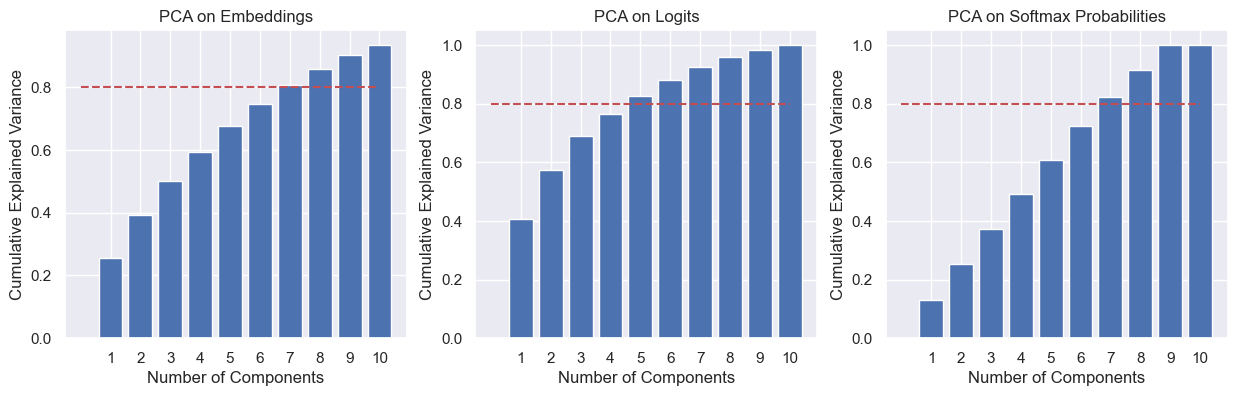

In [18]:
# Figure out how many PCs are required to cover 80% of variance
pca_emb = PCA(n_components=10)
pca_emb.fit(cal_embeddings)

pca_logits = PCA(n_components=10)
pca_logits.fit(logit_extractor(cal_embeddings))

pca_softmax = PCA(n_components=10)
pca_softmax.fit(softmax_extractor(cal_embeddings))

fig, ax = plt.subplots(1,3, figsize=(15,4))

for i, pc in enumerate([pca_emb, pca_logits, pca_softmax]):
    explained_variance = pc.explained_variance_ratio_
    cumulative_variance = np.cumsum(explained_variance)

    ax[i].bar(np.arange(1,len(cumulative_variance)+1), cumulative_variance)
    ax[i].hlines(0.8, 0, len(cumulative_variance), colors='r', linestyles='dashed')
    ax[i].set_xticks(np.arange(1,len(cumulative_variance)+1))
    ax[i].set_xlabel("Number of Components")
    ax[i].set_ylabel("Cumulative Explained Variance")
    if i == 0:
        ax[i].set_title("PCA on Embeddings")
    elif i == 1:
        ax[i].set_title("PCA on Logits")
    else:
        ax[i].set_title("PCA on Softmax Probabilities")
plt.show()


# Try out possible conformal prediction options

In [19]:
tps = cp.TPS(head_model_adapter)
tps.fit(cal_embeddings, cal_labels)
tps_mask = tps.predict(val_embeddings)
sets = tps.convert_to_sets(cifar_labels)

tps_metrics = tps.compute_metrics(val_labels)
# print("TPS Metrics:", tps_metrics)

In [20]:
aps = cp.RAPS(head_model_adapter, lam_reg = 0, k_reg = 0)
aps.fit(cal_embeddings, cal_labels)
aps_mask = aps.predict(val_embeddings)
sets = aps.convert_to_sets(cifar_labels)
aps_metrics = aps.compute_metrics(val_labels)
# print("APS Metrics:", aps_metrics)

In [21]:
raps = cp.RAPS(head_model_adapter, lam_reg=2, k_reg = 0)
raps.fit(cal_embeddings, cal_labels)
raps_mask = raps.predict(val_embeddings)
sets = raps.convert_to_sets(cifar_labels)
raps_metrics = raps.compute_metrics(val_labels)
# print("RAPS Metrics:", raps_metrics)

In [22]:
smoothing_pipeline = Pipeline([
    ('pca', PCA(n_components=8)),
    ('kmeans', KMeans(n_clusters=50, random_state=42))
])

my_smoother = sm.ClusterSmoother(smoothing_pipeline, feature_extractor=logit_extractor)
daps = cp.DAPS(head_model=head_model_adapter, smoother=my_smoother)
daps.fit(cal_embeddings, cal_labels)
daps_mask = daps.predict(val_embeddings)
daps_sets = daps.convert_to_sets(cifar_labels)
daps_metrics = daps.compute_metrics(val_labels)


print("DAPS Metrics on Validation Set with KMeans smoother:")
# print(daps_metrics)

DAPS Metrics on Validation Set with KMeans smoother:


In [23]:
smoothing_pipeline = Pipeline([
    ('pca', PCA(n_components=8)),
    ('dtc', DecisionTreeClassifier(max_depth=5, random_state=42))
])

my_smoother = sm.ClusterSmoother(smoothing_pipeline, feature_extractor=logit_extractor)

daps = cp.DAPS(head_model=head_model_adapter, smoother=my_smoother)
daps.fit(cal_embeddings, cal_labels)
daps_mask = daps.predict(val_embeddings)
daps_sets = daps.convert_to_sets(cifar_labels)
daps_metrics = daps.compute_metrics(val_labels)


print("DAPS Metrics on Validation Set with Decision Tree smoother:")
# print(daps_metrics)

DAPS Metrics on Validation Set with Decision Tree smoother:


In [26]:
smoothing_pipeline = Pipeline([
    ('pca', PCA(n_components=8)),
    ('knn', KNeighborsRegressor(n_neighbors=10, metric='euclidean'))
])

my_smoother = sm.KNNSmoother(smoothing_pipeline)

daps = cp.DAPS(head_model=head_model_adapter, smoother=my_smoother)
daps.fit(cal_embeddings, cal_labels)
daps_mask = daps.predict(val_embeddings)
daps_sets = daps.convert_to_sets(cifar_labels)
daps_metrics = daps.compute_metrics(val_labels)


print("DAPS Metrics on Validation Set with KNN smoother:")
# print(daps_metrics)

DAPS Metrics on Validation Set with KNN smoother:


# Optimize hyperparameters

### Tune RAPS

In [12]:
raps = cp.RAPS(head_model_adapter, alpha=0.1)


# Create the Scorer Object
cp_scorer = make_scorer(
    cp.efficiency_scorer, 
    greater_is_better=True, 
    response_method="predict",  
    target_alpha=0.1            
)

# Define Parameter Grid
param_grid = {
    'lam_reg': [0.0, 0.01, 0.1, 0.2, 0.5, 1, 1.5, 2, 3, 4],  # Regularization weight
    'k_reg': [0, 1, 2, 3]                                    # cutoff for regularization
}

# Setup Grid Search
grid = GridSearchCV(
    estimator=raps,
    param_grid=param_grid,
    scoring=cp_scorer,
    cv=5,                   # 5-fold cross-validation
    verbose=1
)

print("Tuning Hyperparameters on Calibration Data...")
grid.fit(cal_embeddings, cal_labels) 

# Results
print(f"\nBest Parameters: {grid.best_params_}")
print(f"Best Score (Neg Set Size): {grid.best_score_:.4f}")


Tuning Hyperparameters on Calibration Data...
Fitting 5 folds for each of 40 candidates, totalling 200 fits

Best Parameters: {'k_reg': 3, 'lam_reg': 0.5}
Best Score (Neg Set Size): -182.9701


### Tune DAPS

In [13]:
# Define Parameter Grid
param_grid = {
    'lam_reg': [0.0, 0.01, 0.1, 0.2, 0.5, 1, 1.5, 2, 3, 4],  # Regularization weight
    'k_reg': [0, 1, 2],                                      # cutoff for regularization
    'beta' : [0, 0.01, 0.02, 0.03, 0.04, 0.05]               # Diffusion strength
}

# Initialize Model
smoothing_pipeline = Pipeline([
    ('pca', PCA(n_components=5)),
    ('kmeans', KMeans(n_clusters=50, random_state=42))
])

my_smoother = sm.ClusterSmoother(smoothing_pipeline, feature_extractor=logit_extractor)
daps = cp.DAPS(head_model_adapter, my_smoother, alpha=0.1)

# Setup Grid Search
grid = GridSearchCV(
    estimator=daps,
    param_grid=param_grid,
    scoring=cp_scorer,
    cv=5, 
    verbose=1
)

print("Tuning Hyperparameters on Calibration Data...")
grid.fit(cal_embeddings, cal_labels) 

# Results
print(f"\nBest Parameters: {grid.best_params_}")
print(f"Best Score (Neg Set Size): {grid.best_score_:.4f}")


Tuning Hyperparameters on Calibration Data...
Fitting 5 folds for each of 180 candidates, totalling 900 fits

Best Parameters: {'beta': 0.02, 'k_reg': 1, 'lam_reg': 0.1}
Best Score (Neg Set Size): -1.1090


In [27]:
daps = cp.DAPS(head_model_adapter, my_smoother, alpha=0.1, beta = 0.1, k_reg = 1, lam_reg = 0.5)
daps.fit(cal_embeddings, cal_labels)
daps_mask = daps.predict(val_embeddings)
daps_sets = daps.convert_to_sets(cifar_labels)
daps_metrics = daps.compute_metrics(val_labels)


print("DAPS Metrics on Validation Set with Tuned Hyperparameters:")
# print(daps_metrics)

DAPS Metrics on Validation Set with Tuned Hyperparameters:


0.13959390862944165
0.07664974619289344
0.13147208121827414
0.12842639593908634


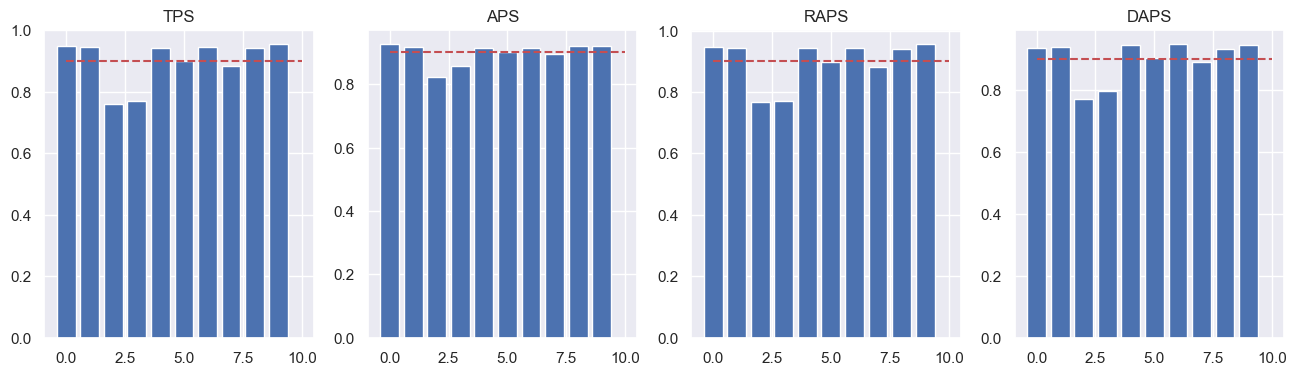

In [29]:
fig, ax = plt.subplots(1,4, figsize=(16,4))
for i, mdl in enumerate([tps_metrics, aps_metrics, raps_metrics, daps_metrics]):
    ax[i].bar(np.arange(len(mdl["Class Conditional Coverage"])), mdl["Class Conditional Coverage"])
    ax[i].set_title(["TPS", "APS", "RAPS", "DAPS"][i])
    ax[i].hlines(0.9, 0, len(mdl["Class Conditional Coverage"]), colors='r', linestyles='dashed')
    print(mdl["Max Class Conditional Deviation"])
plt.show()

## Plot results

In [30]:
# Plot Empirical coverage, avg set size, singleton rate and hit rate of the different models agains alpha levels
smoothing_pipeline = Pipeline([
    ('pca', PCA(n_components=7)),
    ('kmeans', KMeans(n_clusters=50, random_state=42))
])
my_smoother = sm.ClusterSmoother(smoothing_pipeline, feature_extractor=softmax_extractor)
models = {
    "TPS": cp.TPS(head_model=head_model_adapter),
    "APS": cp.RAPS(head_model=head_model_adapter),
    "RAPS": cp.RAPS(head_model=head_model_adapter, lam_reg=1.5, k_reg=0),
    "DAPS": cp.DAPS(head_model=head_model_adapter, smoother=my_smoother, lam_reg=1, k_reg=0, beta=0.1)
}
results = {name: {"Empirical coverage": [], "Efficiency": [], "Singleton rate": [], "Singleton Hit ratio": [], "Max Class Conditional Deviation": []} for name in models.keys()}

alphas = np.linspace(0.02, 0.2, 20)
for alpha in alphas:
    for name, model in models.items():
        model.alpha = alpha
        model.fit(cal_embeddings, cal_labels)
        mask = model.predict(test_embeddings)
        metrics = model.compute_metrics(test_labels)
        for metric in results[name].keys():
            results[name][metric].append(metrics[metric])

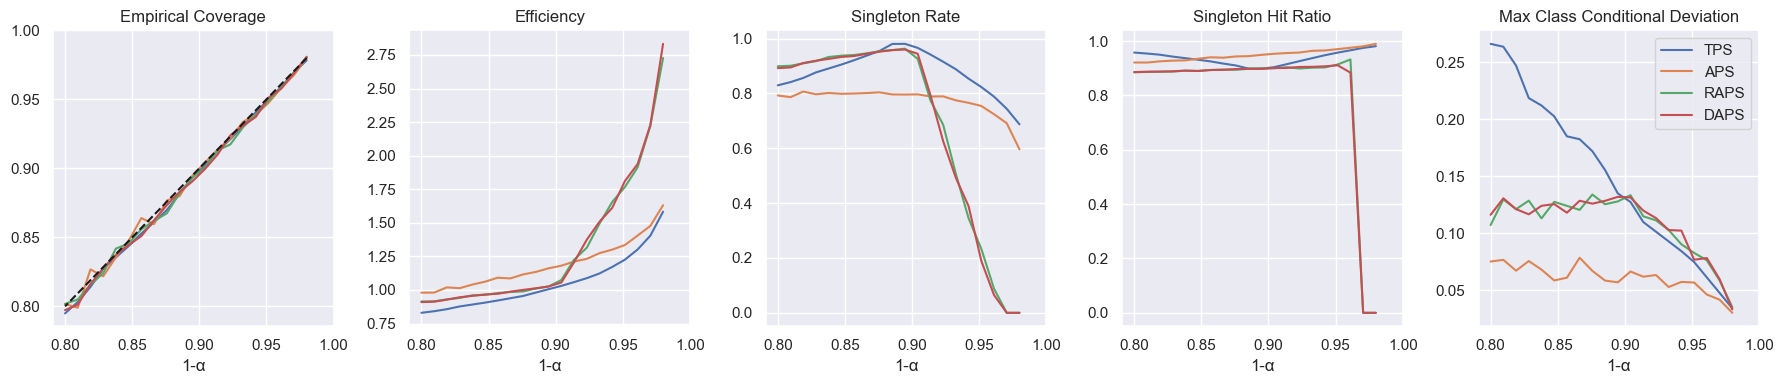

In [31]:
fig, ax = plt.subplots(1,5, figsize=(18, 4))
for i, metric in enumerate(["Empirical coverage", "Efficiency", "Singleton rate", "Singleton Hit ratio", "Max Class Conditional Deviation"]):
    for name in models.keys():
        ax[i].plot(1-alphas, results[name][metric], label=name)
    if metric == "Empirical coverage":
        ax[i].plot(1-alphas, 1 - alphas, 'k--', label="Ideal Coverage")
    
    ax[i].set_xlabel("1-α")
    ax[i].set_xticks(np.arange(0.8, 1.01, 0.05))
    ax[i].set_title(f"{metric.replace('_', ' ').title()}")
ax[0].set_yticks(np.arange(0.8, 1.01, 0.05))
plt.legend()
plt.tight_layout()
plt.show()


## Plot DAPS performance

In [32]:
betas = np.linspace(0, 1, 11)

# For every beta, evaluate DAPS on test set and range of values across all clustering methods and feature extractors
kmeans = KMeans(n_clusters=50, random_state=42)
dtc = DecisionTreeClassifier(max_depth=5, random_state=42)
knn = KNeighborsRegressor(n_neighbors=100, metric='euclidean')

smoother_softmax_kmeans = sm.ClusterSmoother(clustering_model=Pipeline([('pca', PCA(n_components=7)), ('kmeans', kmeans)]),
                                 feature_extractor=softmax_extractor)
smoother_softmax_dtc = sm.ClusterSmoother(clustering_model=Pipeline([('pca', PCA(n_components=7)), ('dtc', dtc)]),
                                 feature_extractor=softmax_extractor)
smoother_softmax_knn = sm.ClusterSmoother(clustering_model=Pipeline([('pca', PCA(n_components=7)), ('knn', knn)]),
                                 feature_extractor=softmax_extractor)

smoother_logit_kmeans = sm.ClusterSmoother(clustering_model=Pipeline([('pca', PCA(n_components=5)), ('kmeans', kmeans)]),
                                 feature_extractor=logit_extractor)
smoother_logit_dtc = sm.ClusterSmoother(clustering_model=Pipeline([('pca', PCA(n_components=5)), ('dtc', dtc)]),
                                 feature_extractor=logit_extractor)
smoother_logit_knn = sm.ClusterSmoother(clustering_model=Pipeline([('pca', PCA(n_components=5)), ('knn', knn)]),
                                 feature_extractor=logit_extractor)

smoother_emb_kmeans = sm.ClusterSmoother(clustering_model=Pipeline([('pca', PCA(n_components=5)), ('kmeans', kmeans)]))
smoother_emb_dtc = sm.ClusterSmoother(clustering_model=Pipeline([('pca', PCA(n_components=5)), ('dtc', dtc)]))
smoother_emb_knn = sm.ClusterSmoother(clustering_model=Pipeline([('pca', PCA(n_components=5)), ('knn', knn)]))

models = {
    "softmax kmeans": cp.DAPS(head_model=head_model_adapter, smoother=smoother_softmax_kmeans, lam_reg=1, k_reg=0),
    "softmax dtc": cp.DAPS(head_model=head_model_adapter, smoother=smoother_softmax_dtc, lam_reg=1.5, k_reg=1),
    "softmax knn": cp.DAPS(head_model=head_model_adapter, smoother=smoother_softmax_knn, lam_reg=1.5, k_reg=1),
    "logit kmeans": cp.DAPS(head_model=head_model_adapter, smoother=smoother_logit_kmeans, lam_reg=1.5, k_reg=0),
    "logit dtc": cp.DAPS(head_model=head_model_adapter, smoother=smoother_logit_dtc, lam_reg=2, k_reg=1),
    "logit knn": cp.DAPS(head_model=head_model_adapter, smoother=smoother_logit_knn, lam_reg=1.5, k_reg=1),
    "emb kmeans": cp.DAPS(head_model=head_model_adapter, smoother=smoother_emb_kmeans, lam_reg=1.5, k_reg=1),
    "emb dtc": cp.DAPS(head_model=head_model_adapter, smoother=smoother_emb_dtc, lam_reg=1.5, k_reg=1),
    "emb knn": cp.DAPS(head_model=head_model_adapter, smoother=smoother_emb_knn, lam_reg=2, k_reg=0),
}

results = {name: {"Empirical coverage": [], "Efficiency": [], "Singleton rate": [], "Singleton Hit ratio": [], "Max Class Conditional Deviation": []} for name in models.keys()}

for beta in betas:
    for name, model in models.items():
        model.beta = beta
        model.fit(cal_embeddings, cal_labels)
        mask = model.predict(test_embeddings)
        metrics = model.compute_metrics(test_labels)
        for metric in results[name].keys():
            results[name][metric].append(metrics[metric])


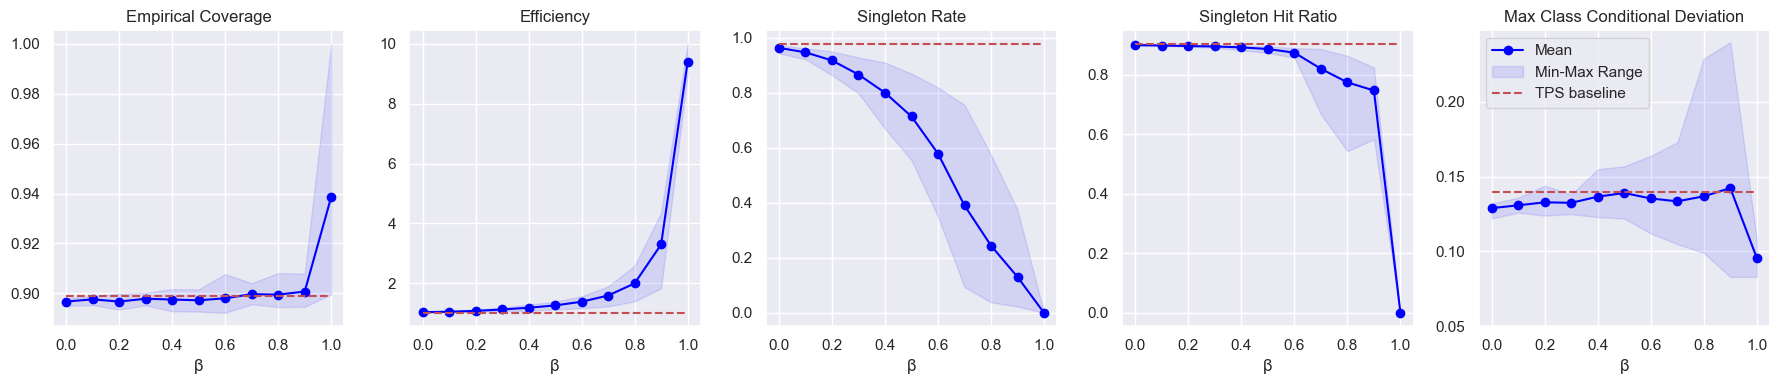

In [33]:
fig, ax = plt.subplots(1,5, figsize=(18,4))
for i, metric in enumerate(["Empirical coverage", "Efficiency", "Singleton rate", "Singleton Hit ratio", "Max Class Conditional Deviation"]):
    values = np.zeros((len(models), len(betas)))
    for n, name in enumerate(models.keys()):
        values[n] = results[name][metric]
    mean = np.mean(values, axis=0)
    ax[i].plot(betas, mean, label="Mean", marker='o', color='blue')
    ax[i].fill_between(betas, np.min(values, axis=0), np.max(values, axis=0), color='blue', alpha=0.1, label="Min-Max Range")
    ax[i].plot(np.array([0,1]), np.array([tps_metrics[metric], tps_metrics[metric]]), 'r--', label="TPS baseline")
    ax[i].set_xlabel("β")
    ax[i].set_title(f"{metric.replace('_', ' ').title()}")
ax[-1].set_yticks(np.arange(0.05, 0.21, 0.05))
plt.tight_layout()
plt.legend()
plt.show()